# Removing bias enables generalization

In this notebook, we look at the generalization comparisons between a given model (e.g. DnCNN), and its bias free  version (e.g. BF_DnCNN). 

Inside the training range, the two models show comparable performance. However, outside the training range, bias free network, outperforms the other network significantly. 

In this notebook, we look at

1. comparative performance of the models on single images. 

2. comparative performance of the models averaged across many images. 



In [1]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import torch
import torch.nn as nn

import argparse
from torch.serialization import default_restore_location

import os
import sys  
import models
from skimage import io
import pickle
from demo_utils import *
import utils

%matplotlib inline


In [2]:
pretrained_base = './pretrained/'
precomputed_base = './precomputed/'
data_base = 'data/'

In [3]:
# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 

# Choose a model 


### and load both versions of it: with bias and bias free

The following pre-tained models are available in the repository in both with bias and bias free versions: 

'dncnn', 'unet', 'rcnn', 'sdensenet'

You can train and use any other model using the train script provided in the repository. 

In [4]:
model = 'dncnn' 

# select the range which the network has been trained on:
min_noise = 0
max_noise = 10

### Show 4 random noisy images used during training for this model 


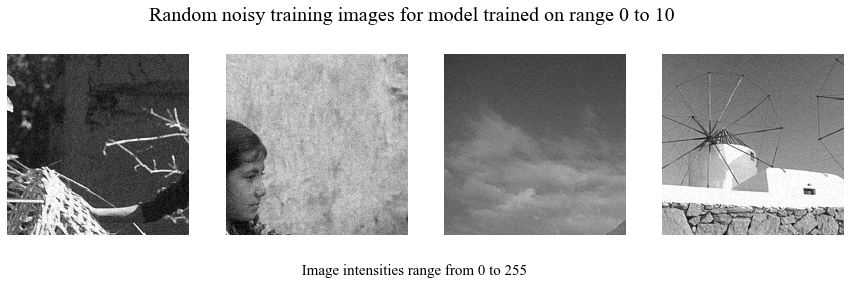

In [5]:
f, axs = plt.subplots(1,4, figsize = (15,4), squeeze=True)
f.suptitle('Random noisy training images for model trained on range ' + str(min_noise) +' to '+ str(max_noise),  fontname= 'Times New Roman', fontsize = 20)
f.text(.5, .05, ' Image intensities range from 0 to 255',ha='center',  fontname= 'Times New Roman', fontsize = 15)
for i in range(4): 
    tr_im_n = np.random.randint(0,len(os.listdir(train_folder_path)))
    tr_im = single_image_loader(train_folder_path, tr_im_n)
    tr_dim1, tr_dim2 = tr_im.shape
    tr_noisy, _ = add_noise(tr_im.reshape(1,tr_dim1,tr_dim2), [min_noise,max_noise], 'B') 
    tr_noisy = tr_noisy.reshape(tr_dim1,tr_dim2)
    axs[i].imshow(tr_noisy, 'gray', vmin= 0, vmax = 1)
    axs[i].axis('off');

## 1. Comparing performance on a single image 

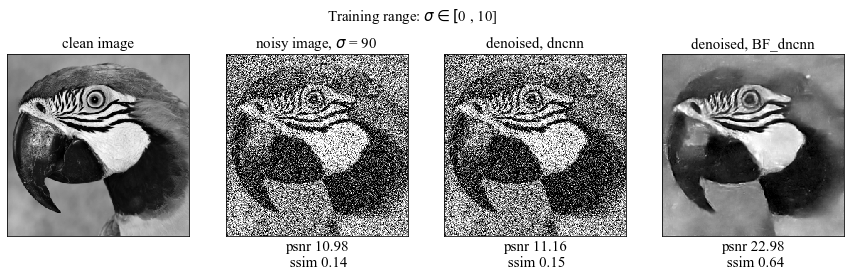

In [6]:
def load_model(checkpoint_path):
    state_dict = torch.load(checkpoint_path, map_location=lambda s, l: default_restore_location(s, "cpu"))
    args = argparse.Namespace(**{ **vars(state_dict["args"]), "no_log": True})

    model = models.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

CNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))
display_denoising(CNN, BF_CNN, set12_path, 
                          image_num=6, noise_level = 90, l = min_noise, h=max_noise, model = model);
    

## 2. Comparing performance across many images

The following plot shows output PSNR against input PSNR for the CNN and BF_CNN versions of the selected model. These metrics have been pre-calculated. If you want to compute PSNR or SSIM again, or on another dataset, or on another datset, or for a new model, set USE_PRECOMPUTED_METRICS to False. 


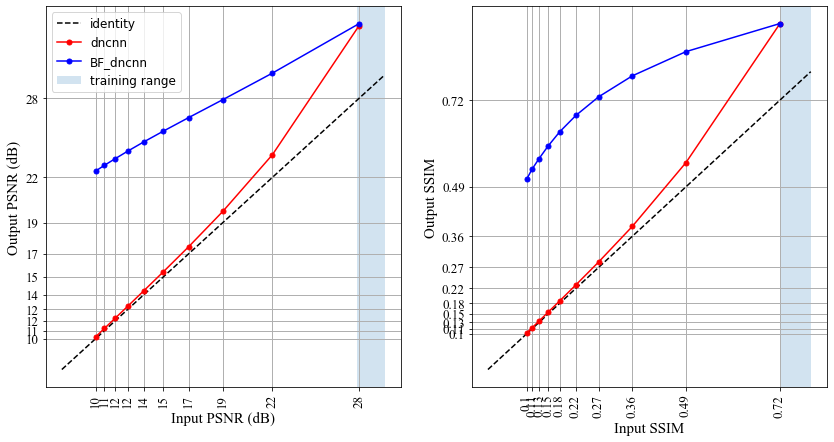

In [7]:
USE_PRECOMPUTED_METRICS = True

compute_and_plot_performance_plot(model, min_noise, max_noise, pretrained_base,precomputed_base, USE_PRECOMPUTED_METRICS)
